Data Preprocessing and imports

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# --- 1. Data Loading (as in notebook) ---
base_path = "data/"
files = {
    "contribution": ("Zusatzbeitrag_je Kasse je Quartal.xlsx", "Sheet1"),
    "morbidity": ("Morbidity_Region.xlsx", "data"),
    "market": ("Marktanteile je Kasse.xlsx", "data")
}

dataframes = {}
for name, (filename, sheetname) in files.items():
    full_path = os.path.join(base_path, filename)
    df = pd.read_excel(full_path, sheet_name=sheetname)
    dataframes[name] = df

for df in dataframes.values():
    df["Krankenkasse"] = df["Krankenkasse"].str.strip().str.lower()
    df["Jahr"] = df["Jahr"].astype(int)

merged = pd.merge(
    dataframes["contribution"],
    dataframes["morbidity"][["Krankenkasse", "Jahr", "Risikofaktor"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)
merged = pd.merge(
    merged,
    dataframes["market"][["Krankenkasse", "Jahr", "Marktanteil Mitglieder", "Marktanteil Versicherte"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)

# Drop rows with missing 'Mitglieder' or 'Zusatzbeitrag'
merged = merged.dropna(subset=['Mitglieder', 'Zusatzbeitrag'])

# --- 2. Feature Engineering ---
# Sort and calculate churn
merged = merged.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
merged['members_prev'] = merged.groupby('Krankenkasse')['Mitglieder'].shift(1)
merged['churn_abs'] = merged['Mitglieder'] - merged['members_prev']
merged['churn_rel'] = merged['churn_abs'] / merged['members_prev'] * 100

# Contribution rate change
merged['Zusatzbeitrag_prev'] = merged.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)
merged['rate_change'] = merged['Zusatzbeitrag'] - merged['Zusatzbeitrag_prev']

print(merged.columns)

Index(['Jahr', 'Krankenkasse', 'Quartal', 'Mitglieder', 'Versicherte',
       'Zusatzbeitrag', 'Risikofaktor', 'Marktanteil Mitglieder',
       'Marktanteil Versicherte', 'members_prev', 'churn_abs', 'churn_rel',
       'Zusatzbeitrag_prev', 'rate_change'],
      dtype='object')


In [3]:
# More preprocessing
# --- Competitor Contribution Feature ---
def compute_competitor_contribution(df):
    # For each row, compute the mean contribution of all other funds in the same year/quarter
    df['competitor_contribution'] = df.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].transform(lambda x: (x.sum() - x) / (len(x) - 1))
    return df

merged = compute_competitor_contribution(merged)
# --- Prepare Features ---
# Convert to numeric
merged['Risikofaktor'] = pd.to_numeric(merged['Risikofaktor'], errors='coerce')
merged['Marktanteil Mitglieder'] = pd.to_numeric(merged['Marktanteil Mitglieder'], errors='coerce')
merged['Zusatzbeitrag'] = pd.to_numeric(merged['Zusatzbeitrag'], errors='coerce')
merged['competitor_contribution'] = pd.to_numeric(merged['competitor_contribution'], errors='coerce')

# Drop rows with missing values in key features
features = ['Zusatzbeitrag', 'competitor_contribution', 'Risikofaktor', 'Marktanteil Mitglieder']
merged = merged.dropna(subset=features + ['churn_rel'])

In [4]:
#Training a Random Forest Model to predict churn and contribution

# --- Regression Target ---
X = merged[features]
y_reg = merged['churn_rel']

# --- Classification Target (e.g., churn above median = 1, else 0) ---
median_churn = y_reg.median()
y_clf = (y_reg > median_churn).astype(int)

# --- Train/Test Split ---
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)

# --- Regression Model ---
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_reg_train)
y_reg_pred = reg.predict(X_test)

print("--- Regression Results ---")
print(f"RMSE: {np.sqrt(mean_squared_error(y_reg_test, y_reg_pred)):.3f}")
print(f"R^2: {r2_score(y_reg_test, y_reg_pred):.3f}")
print("Feature importances:")
for name, imp in zip(features, reg.feature_importances_):
    print(f"  {name}: {imp:.3f}")

--- Regression Results ---
RMSE: 1.192
R^2: 0.286
Feature importances:
  Zusatzbeitrag: 0.248
  competitor_contribution: 0.328
  Risikofaktor: 0.240
  Marktanteil Mitglieder: 0.184


Feature Selections

In [10]:

# --- Final feature selection ---
# df['Risikofaktor'] = pd.to_numeric(df['Risikofaktor'], errors='coerce')
# df['Marktanteil Mitglieder'] = pd.to_numeric(df['Marktanteil Mitglieder'], errors='coerce')

features = ['Zusatzbeitrag', 'competitor_contribution', 'Risikofaktor', 'Marktanteil Mitglieder']
# df = df.dropna(subset=features + ['churn_rel'])

X = merged[features]
y = merged['churn_rel']

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Random Forest Model

In [16]:
# --- Model Training ---
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# --- Evaluation ---
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Model Performance ---")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

print("\nFeature Importances:")
for name, importance in zip(features, model.feature_importances_):
    print(f"{name}: {importance:.3f}")


--- Model Performance ---
RMSE: 1.20
R²: 0.27

Feature Importances:
Zusatzbeitrag: 0.246
competitor_contribution: 0.321
Risikofaktor: 0.245
Marktanteil Mitglieder: 0.187


Gradient Boosting

In [17]:
from sklearn.ensemble import GradientBoostingRegressor


gradient_boosting_model = GradientBoostingRegressor(n_estimators=1000, random_state=42)
gradient_boosting_model.fit(X_train, y_train)

y_pred = gradient_boosting_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Gradient Boosting Model Performance ---")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print("\nFeature Importances:")
for name, importance in zip(features, gradient_boosting_model.feature_importances_):
    print(f"{name}: {importance:.3f}")


--- Gradient Boosting Model Performance ---
RMSE: 1.35
R²: 0.08

Feature Importances:
Zusatzbeitrag: 0.250
competitor_contribution: 0.332
Risikofaktor: 0.183
Marktanteil Mitglieder: 0.235


In [30]:
merged.Krankenkasse

3403    actimonda krankenkasse
3404    actimonda krankenkasse
3405    actimonda krankenkasse
3406    actimonda krankenkasse
2952    actimonda krankenkasse
                 ...          
470                    wmf bkk
471                    wmf bkk
472                    wmf bkk
473                    wmf bkk
93                     wmf bkk
Name: Krankenkasse, Length: 3584, dtype: object

In [38]:
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

y_pred = linear_regression_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Gradient Boosting Model Performance ---")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


--- Gradient Boosting Model Performance ---
RMSE: 1.26
R²: 0.21


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import TweedieRegressor, PoissonRegressor, GammaRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(max_iter=10000),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor(),
    "SVR": SVR(),
    "MLPRegressor": MLPRegressor(max_iter=500),
    "KernelRidge": KernelRidge(),
    "XGBRegressor": XGBRegressor(verbosity=0, n_estimators=1000, random_state=42),
    "LGBMRegressor": LGBMRegressor(),
    "CatBoostRegressor": CatBoostRegressor(verbose=0)
}

# Results
results = []

print("\nTraining and evaluating models...\n")
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append((name, round(rmse, 3), round(r2, 3)))
    except Exception as e:
        results.append((name, "Error", str(e)))

# Display as table
df_results = pd.DataFrame(results, columns=["Model", "RMSE", "R²"])
print(tabulate(df_results, headers='keys', tablefmt='fancy_grid'))



Training and evaluating models...

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 4
[LightGBM] [Info] Start training from score 0.471634
╒════╤══════════════════════╤════════╤════════╕
│    │ Model                │   RMSE │     R² │
╞════╪══════════════════════╪════════╪════════╡
│  0 │ LinearRegression     │  1.257 │  0.206 │
├────┼──────────────────────┼────────┼────────┤
│  1 │ Ridge                │  1.257 │  0.206 │
├────┼──────────────────────┼────────┼────────┤
│  2 │ Lasso                │  1.411 │ -0     │
├────┼──────────────────────┼────────┼────────┤
│  3 │ ElasticNet           │  1.411 │ -0     │
├────┼──────────────────────┼────────┼────────┤
│  4 │ DecisionTr

In [8]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming your data is in X, y
# X, y = ... # Load your features and target here
# Example: from sklearn.datasets import load_diabetes
# X, y = load_diabetes(return_X_y=True)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'l2_regularization': [0, 1, 5],
}

# Define model
model = HistGradientBoostingRegressor(random_state=42)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest parameters found:")
print(grid_search.best_params_)

# Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nTest RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=200; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=200; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=200; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=200; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=3, max_iter=30

Training HistGradientBoosting...


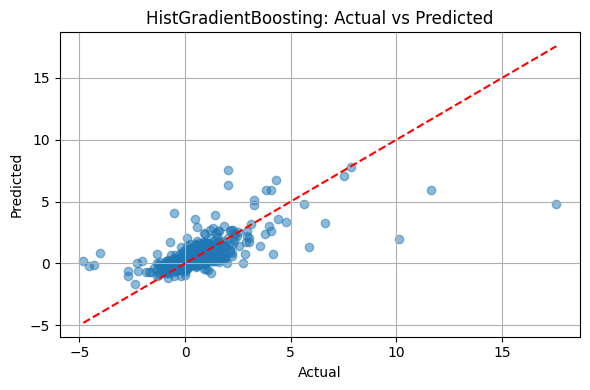

Training LGBMRegressor...


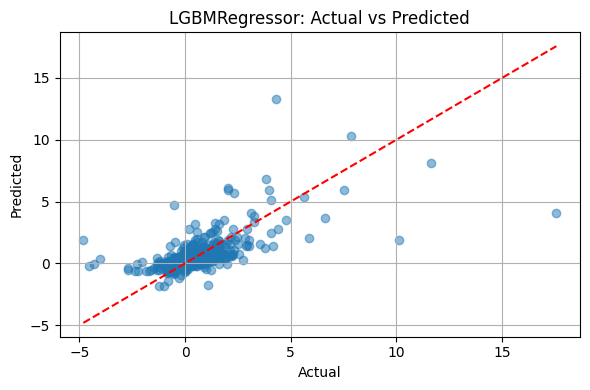

Training GradientBoosting...


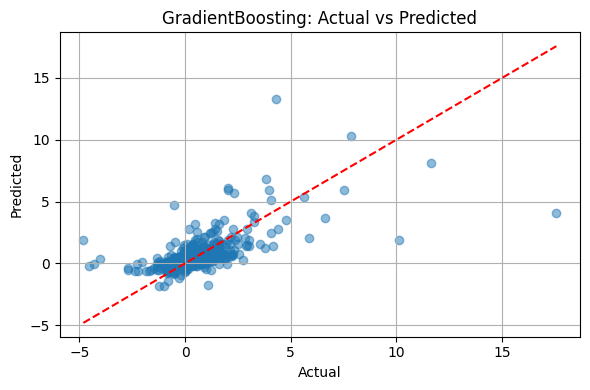

Training RandomForest...


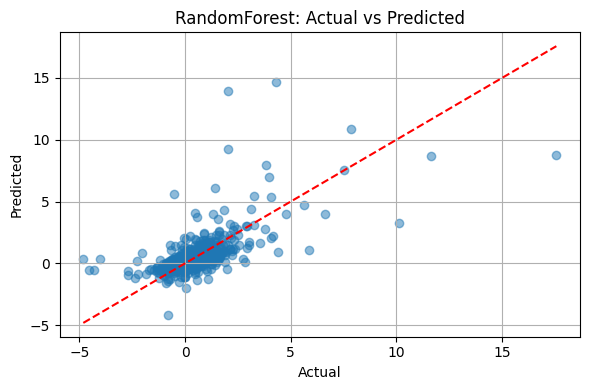

Training MLPRegressor...


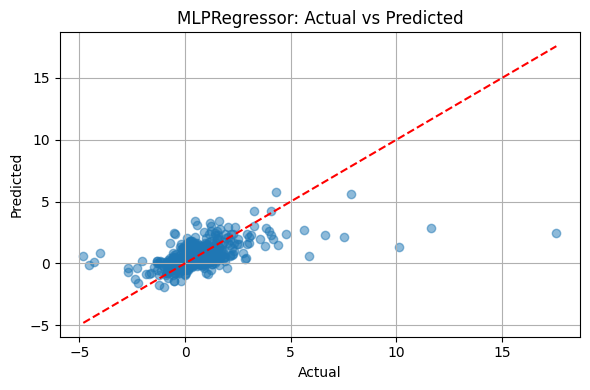


Model Evaluation Summary:
| Model                |   RMSE |    R² |   CV RMSE |
|:---------------------|-------:|------:|----------:|
| HistGradientBoosting |  1.037 | 0.459 |     1.443 |
| LGBMRegressor        |  1.116 | 0.374 |     1.573 |
| GradientBoosting     |  1.116 | 0.374 |     1.597 |
| MLPRegressor         |  1.158 | 0.326 |     1.464 |
| RandomForest         |  1.193 | 0.284 |     1.599 |


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# Split & scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Top 5 models based on your table
models = {
    "HistGradientBoosting": HistGradientBoostingRegressor(    l2_regularization=0,
    learning_rate=0.05,
    max_depth=7,
    max_iter=100
),
    "LGBMRegressor": GradientBoostingRegressor(),  # Replace with LGBMRegressor if LightGBM is installed
    "GradientBoosting": GradientBoostingRegressor(),
    "RandomForest": RandomForestRegressor(),
    "MLPRegressor": MLPRegressor(max_iter=1000)
}

results = []

# Evaluation loop
for name, model in models.items():
    print(f"Training {name}...")
    if name == "HistGradientBoosting":
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        cv_rmse = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=5).mean()
    else:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        cv_rmse = -cross_val_score(model, scaler.transform(X), y, scoring='neg_root_mean_squared_error', cv=5).mean()

    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "RMSE": round(rmse, 3),
        "R²": round(r2, 3),
        "CV RMSE": round(cv_rmse, 3)
    })

    # Plot actual vs predicted
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name}: Actual vs Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Results table
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="RMSE")
print("\nModel Evaluation Summary:")
print(df_results.to_markdown(index=False))


In [21]:
import seaborn as sns

def plot_model_diagnostics(models, X_test, y_test):
    """
    models: list of trained models
    model_names: list of string names corresponding to models
    X_test, y_test: test features and labels
    """
    sns.set(style="whitegrid")
    n = len(models)
    fig, axes = plt.subplots(n, 2, figsize=(12, 4 * n))

    if n == 1:
        axes = [axes]  # Ensure it's 2D
    i = 0
    for name, model in models.items():
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Plot 1: Actual vs. Predicted
        axes[i][0].scatter(y_test, y_pred, alpha=0.6)
        axes[i][0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        axes[i][0].set_title(f"{name} | Actual vs. Predicted\nRMSE: {rmse:.3f}, R²: {r2:.3f}")
        axes[i][0].set_xlabel("Actual")
        axes[i][0].set_ylabel("Predicted")

        # Plot 2: Residuals
        sns.histplot(residuals, kde=True, ax=axes[i][1], color='orange', bins=30)
        axes[i][1].axvline(0, color='red', linestyle='--')
        axes[i][1].set_title(f"{name} | Residuals Distribution")
        axes[i][1].set_xlabel("Residual (Actual - Predicted)")
        axes[i][1].set_ylabel("Frequency")
        i += 1

    plt.tight_layout()
    plt.show()


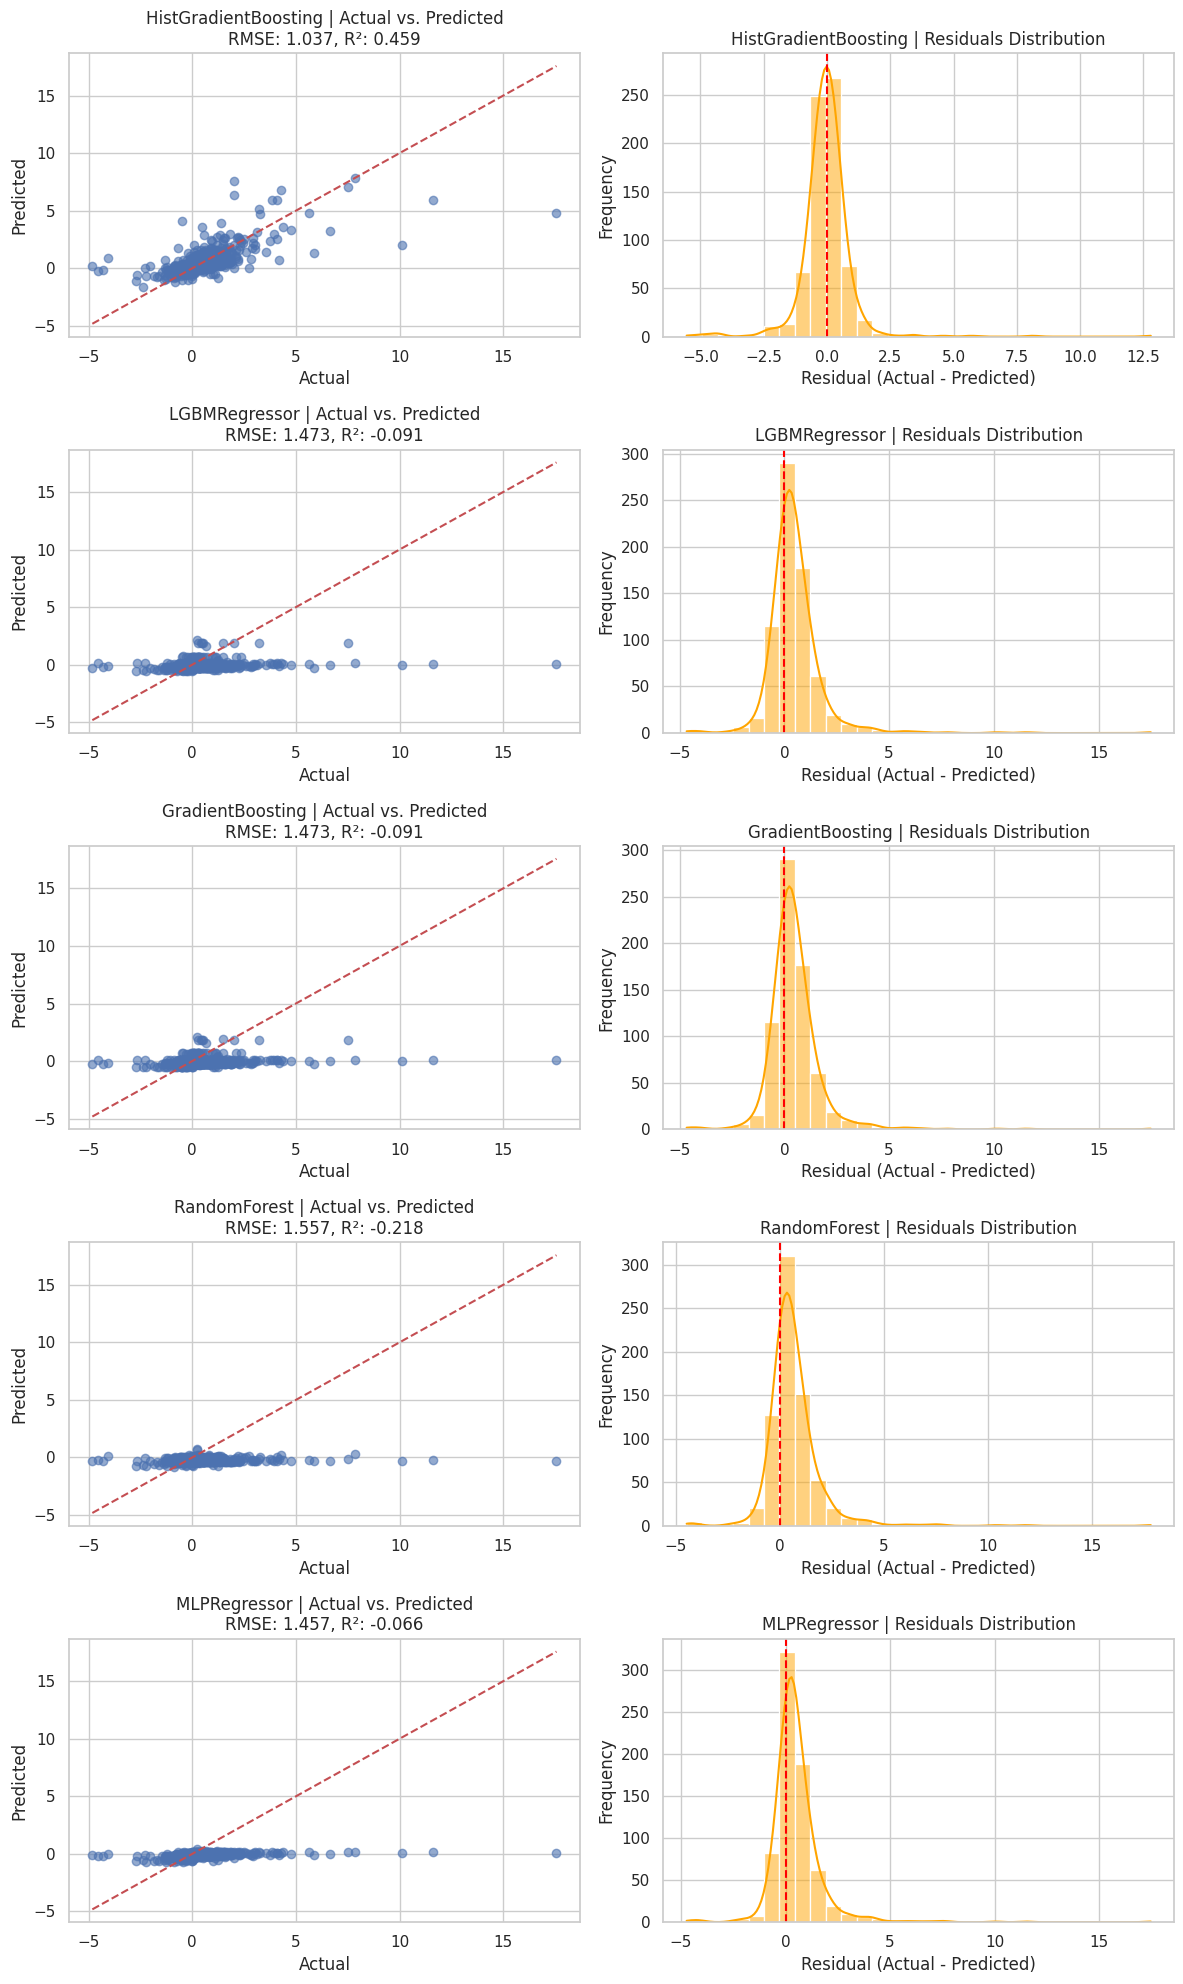

In [22]:

plot_model_diagnostics(models=models, X_test=X_test,y_test= y_test)
